In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import sklearn.metrics as metrics

/home/mpir0002/miniconda3/envs/tf/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/mnt/market/anclab-rstudio-server/home/mpir0002/miniconda3/envs/tf/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
BATCH_SIZE = 32

## transformations
transform = transforms.Compose([transforms.ToTensor()])

## download and load training dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2) # trainloader is an iterator

## download and load testing dataset
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

In [3]:
print(len(trainset))
print(len(trainset[10])) # a tuple of length 2, containing features and label of the image 
print(trainset[10][1]) # label of image 10
#print(trainset[10][0]) # features of the image
print(trainset[10][0].shape) # torch.Size([1, 28, 28])

60000
2
3
torch.Size([1, 28, 28])


In [ ]:

# Important notes:
# When you loop over a DataLoader in PyTorch, each iteration of the loop retrieves a batch of data, not a single data point.

# the input to nn.Linear in PyTorch must be a 2D tensor where the first dimension is typically interpreted as the batch size, and the second dimension is the number of features for each data point. The nn.Linear module expects its input in this format because it performs a linear transformation (matrix multiplication followed by adding a bias) on the feature dimension of each data point in the batch.


In [7]:
class mymodel(nn.Module):
    def __init__(self):
        super(mymodel , self).__init__()

        self.conv1 = nn.Conv2d(in_channels = 1 , out_channels = 24 , kernel_size = 3)
        self.d1 = nn.Linear(26*26*24 , 128)
        self.d2 = nn.Linear(128 , 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)

        x = x.flatten(start_dim = 1)

        x = self.d1(x)
        x = F.relu(x)

        logits = self.d2(x)
        out = F.softmax(logits , dim=1)
        return out
        

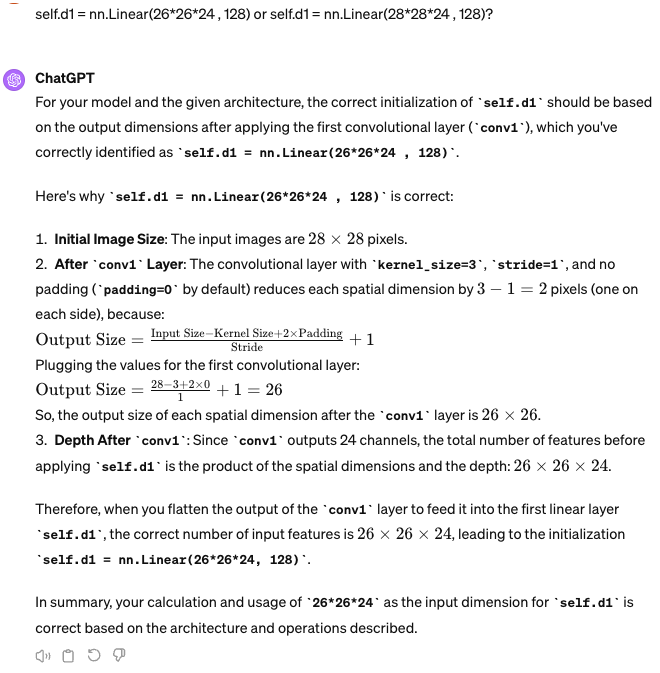

In [5]:
from IPython.display import Image
Image("/mnt/market/anclab-rstudio-server/home/mpir0002/DeepMAPS/nn.Conv2d.png")

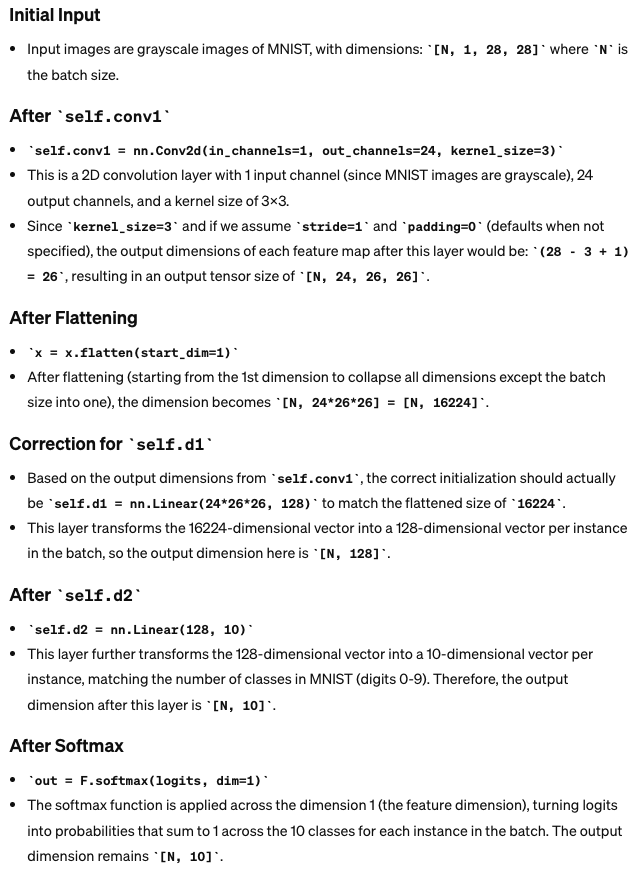

In [6]:
Image("/mnt/market/anclab-rstudio-server/home/mpir0002/DeepMAPS/Dimensions.png")

In [8]:
import numpy as np
#ctr + shift + minus

In [ ]:
a = np.array([[1,2],[3,4]])
b = np.ones((2,2))

ta = torch.tensor(a, dtype=float).to('cuda:0')
tb = torch.ones(2,2, dtype=float).to('cuda:0')

print(ta)
print(ta @ tb)

In [4]:
torch.cuda.is_available()

False

In [8]:
learning_rate = 0.001
num_epochs = 5
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = mymodel()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters() , lr = learning_rate)

In [14]:
for epoch in range(num_epochs):
    train_loss = 0.0
    train_acc = 0.0

    for i, (images , labels) in enumerate(trainloader):
        images = images.to(device)
        labels = labels.to(device)
        
        logits = model(images)
        loss = criterion(logits , labels)
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()

        train_loss += loss.detach().item()
        train_acc += (torch.argmax(logits , 1).flatten() == labels).type(torch.float).mean().item()
        
        

In [15]:
print(train_loss)
print(train_acc)

2760.0581953525543
1855.90625


In [9]:
test_acc = 0.0
for i, (images, labels) in enumerate(testloader , 0):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    test_acc += (torch.argmax(outputs, 1).flatten() == labels).type(torch.float).mean().item()
    preds = torch.argmax(outputs , 1).flatten().cpu().numpy()

print('Test Accuracy: %.2f'%(test_acc/i))

Test Accuracy: 0.10


In [12]:
test_acc = 0.0
for i, (images, labels) in enumerate(testloader):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    test_acc += (torch.argmax(outputs, 1).flatten() == labels).type(torch.float).mean().item()
    preds = torch.argmax(outputs, 1).flatten().cpu().numpy()
        
print('Test Accuracy: %.2f'%(test_acc/i))

Test Accuracy: 0.10


In [13]:
preds

array([6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 6, 6, 5, 6, 6, 5])

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils

import time
from datetime import datetime

import networkx as nx
import numpy as np
import torch
import torch.optim as optim

from torch_geometric.datasets import TUDataset
from torch_geometric.datasets import Planetoid
from torch_geometric.data import DataLoader

import torch_geometric.transforms as T

from tensorboardX import SummaryWriter
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


In [ ]:
class GNNStack(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, task='node'):
        super(GNNStack, self).__init__()
        self.task = task
        self.convs = nn.ModuleList()
        self.convs.append(self.build_conv_model(input_dim, hidden_dim))
        self.lns = nn.ModuleList()
        self.lns.append(nn.LayerNorm(hidden_dim))
        self.lns.append(nn.LayerNorm(hidden_dim))
        for l in range(2):
            self.convs.append(self.build_conv_model(hidden_dim, hidden_dim))

        # post-message-passing
        self.post_mp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim), nn.Dropout(0.25), 
            nn.Linear(hidden_dim, output_dim))
        if not (self.task == 'node' or self.task == 'graph'):
            raise RuntimeError('Unknown task.')

        self.dropout = 0.25
        self.num_layers = 3

    def build_conv_model(self, input_dim, hidden_dim):
        # refer to pytorch geometric nn module for different implementation of GNNs.
        if self.task == 'node':
            return pyg_nn.GCNConv(input_dim, hidden_dim)
        else:
            return pyg_nn.GINConv(nn.Sequential(nn.Linear(input_dim, hidden_dim),
                                  nn.ReLU(), nn.Linear(hidden_dim, hidden_dim)))

    def forward(self, data): # This forward is specific to GNNs.
        x, edge_index, batch = data.x, data.edge_index, data.batch
        if data.num_node_features == 0:
          x = torch.ones(data.num_nodes, 1)

        for i in range(self.num_layers): # Loop over all self.convs layers
            x = self.convs[i](x, edge_index)
            emb = x
            x = F.relu(x)
            # # Apply dropout during training: training=self.training
            x = F.dropout(x, p=self.dropout, training=self.training)
            if not i == self.num_layers - 1:
                x = self.lns[i](x)
        
        if self.task == 'graph':
            x = pyg_nn.global_mean_pool(x, batch)
        # pyg_nn.global_mean_pool(x, batch) is a conditional operation that applies only for graph-level tasks, aggregating node features across each graph in the batch to create a single representative vector per graph for subsequent prediction tasks.
        x = self.post_mp(x)

        return emb, F.log_softmax(x, dim=1)

    def loss(self, pred, label):
        return F.nll_loss(pred, label)

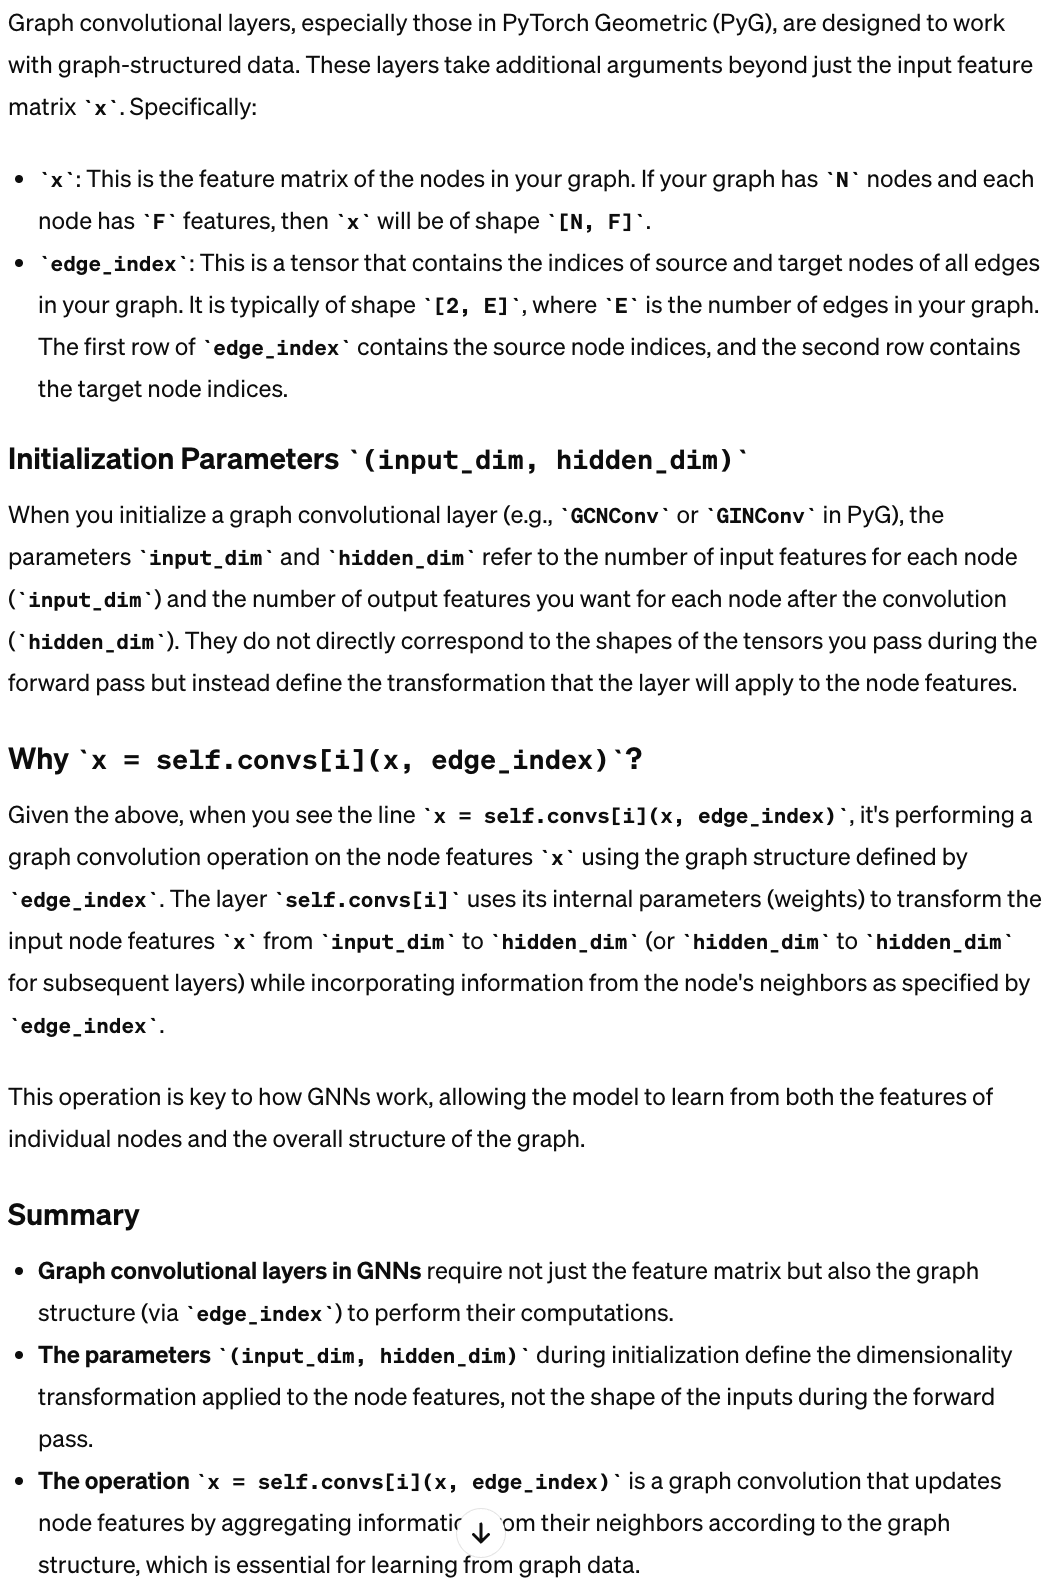

In [2]:
from IPython.display import Image
Image("/mnt/market/anclab-rstudio-server/home/mpir0002/DeepMAPS/GCNConv_forward.png")

In [ ]:
def build_conv_model(self, input_dim, hidden_dim):
        # refer to pytorch geometric nn module for different implementation of GNNs.
        if self.task == 'node':
            return pyg_nn.GCNConv(input_dim, hidden_dim)
        else:
            return pyg_nn.GINConv(nn.Sequential(nn.Linear(input_dim, hidden_dim),
                                  nn.ReLU(), nn.Linear(hidden_dim, hidden_dim)))

In [ ]:

# input_dim: The dimensionality of node features or input data.
# hidden_dim: The dimensionality of the hidden representation or output data after convolution. 

#The constructor of pyg_nn.GINConv takes a single argument, which is a torch.nn.Sequential object. This Sequential object defines a sequence of operations to be applied to the input features during the graph convolution process.
#In the provided code snippet, the Sequential object consists of two linear layers with ReLU activation in between.

#The process doesn't sequentially add "one layer of GCN, then two layers of normalization, followed by another two layers of GCN." Instead, it constructs a ModuleList of three convolutional layers (first one from input_dim to hidden_dim, followed by two more that work from hidden_dim to hidden_dim) and separately initializes a ModuleList of two layer normalization modules configured for hidden_dim-sized features. The exact sequence of applying these layers and normalization modules would be defined in the forward method of the model, which is not provided in your snippet.

In [ ]:
# post-message-passing
        self.post_mp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim), nn.Dropout(0.25), 
            nn.Linear(hidden_dim, output_dim))
        if not (self.task == 'node' or self.task == 'graph'):
            raise RuntimeError('Unknown task.')

        self.dropout = 0.25
        self.num_layers = 3


In [ ]:
class GNNStack(nn.module):
    def __init__(self , input_dim , hidden_dim, output_dim, task='node'):
        super(GNNStack , self).__init__()
        self.task = task
        self.conv = nn.ModuleList()
        self.conv.append(self.build_conv_model(input_dim , hidden_dim))
        for l in range(2):
            self.convs.append(self.build_conv_model(hidden_dim, hidden_dim))
        self.lns = nn.ModuleList()
        self.lns.append(nn.LayerNorm(hidden_dim))
        self.lns.append(nn.LayerNorm(hidden_dim))
        
        # There are three layers of GNN 
        
    

In [ ]:
def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        if data.num_node_features == 0:
          x = torch.ones(data.num_nodes, 1)

        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            emb = x
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
            if not i == self.num_layers - 1:
                x = self.lns[i](x)

# Inputs and Preparation
#Extracting Data: The method starts by extracting x (node features), edge_index (graph connectivity in COO format), and batch (batch information for graph-level tasks) from the input data.

#Handling Graphs Without Node Features: If the input graph does not have node features (data.num_node_features == 0), a feature vector of ones is created for each node. This ensures that the model can still operate even in the absence of explicit node features.

#Forward Pass Through Layers
#Convolutional Layers: The model iterates over each convolutional layer stored in self.convs (the number of iterations is determined by self.num_layers, which you've mentioned elsewhere to be 3). For each layer:

#The graph convolution is applied to x using the current layer and the edge_index. This operation updates the node features based on the graph structure and the layer's parameters.
#The result of this convolution (emb) is stored in emb, which seems intended to capture the node embeddings after the last convolutional operation. However, as emb is overwritten on each iteration, it actually ends up storing only the embeddings from the last convolutional layer.
#A ReLU non-linearity is applied to introduce non-linear transformations into the model.
#Dropout is applied to prevent overfitting by randomly zeroing some of the features during training. The dropout rate is self.dropout.
#Layer Normalization: After dropout (and non-linearity), if the current layer is not the last one (i != self.num_layers - 1), layer normalization is applied through self.lns[i]. This is designed to stabilize the learning process by normalizing the layer outputs.



In [ ]:
if self.task == 'graph':
    x = pyg_nn.global_mean_pool(x, batch)
    
#Handling Graph-level Tasks
#Graph Pooling (if self.task == 'graph'): If the model is set to handle graph-level tasks, pyg_nn.global_mean_pool is applied to aggregate node features (x) across each graph in the batch into a single vector. This pooling operation uses the batch information, which indicates the graph to which each node belongs, to compute the mean of node features for each graph. The result is a batch of graph-level representations, one per graph in the input batch.


In [ ]:

x = self.post_mp(x)

return emb, F.log_softmax(x, dim=1)

def loss(self, pred, label):
    return F.nll_loss(pred, label)

#Post-message-passing Module
#Applying Post-message-passing Layers: The pooled graph representations (for graph tasks) or the final node features (for node tasks) are then processed through a sequence of layers defined in self.post_mp. This sequential module typically includes linear transformations, dropout, and potentially other operations, designed to transform the features into the final output dimension, suitable for the prediction task.

#Generating Predictions: The transformed features are passed through a log_softmax function, which computes the logarithm of the softmax of the features across dim=1. This operation is used to generate predictions for a classification task, ensuring that the output values are log probabilities that sum to 1 across the classes for each instance (node or graph). The log_softmax output is particularly suitable for classification tasks and is compatible with the negative log likelihood loss used for training.


In [ ]:

#Your CustomConv() class cleverly combines feature transformation for self-loops and neighbor aggregation into a single layer, closely aligning with the principles of GCN. To fully implement a GCN layer, consider adding self-loops back to edge_index before propagation and applying the normalization factor in the message function. This would ensure that node features are correctly updated based on both their own features and those of their neighbors, scaled appropriately by the graph's connectivity

# We want to improve conectivity and feature matrix in CustomConv() class

# When you're building a custom layer by extending the MessagePassing class, you typically override both of these methods to define the behavior of your graph neural network layer. The forward method handles the high-level flow of data, including pre- and post-processing, and the message method focuses on the details of how messages are constructed and passed between nodes.

In [ ]:
class CustomConv(pyg_nn.MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(CustomConv, self).__init__(aggr='add')  # Specify the aggregation mode.
        self.lin = nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        # Starts the message passing process
        return self.propagate(edge_index, x=x)

    def message(self, x_j):
        # Custom message function
        return self.lin(x_j)


In [ ]:
# Yes, it does. When you define the `message` method in a class that inherits from PyTorch Geometric's `MessagePassing` class and then call `self.propagate()`, the `message` method you've defined is automatically used during the message passing process, even though you define `message` after calling `self.propagate()` in the code. This is because of how Python classes work, not because of the order of execution in the script.

# Here's a simplified explanation of why this works:

# 1. **Class Definition**: In Python, the class definition (including all its methods) is read and processed as a whole. When you define a class that inherits from another class and override a method (like `message`), Python knows that your version of `message` should be used instead of the parent class's version, regardless of where it's defined within your class.

# 2. **Method Resolution Order (MRO)**: Python uses a method resolution order to determine which method to invoke. When you call `self.propagate()` in your `forward` method, and `propagate` internally needs to call `message`, Python looks up the MRO and calls your implementation of `message`, because it overrides the parent class's method.

# 3. **Runtime Behavior**: The actual message passing (i.e., the invocation of `self.propagate()` and subsequently `self.message()`) happens at runtime, when the `forward` method of your model is called with some input data. At this point, all methods of the class are fully defined and known to Python, so it correctly uses your `message` method.

# ### How `propagate` Uses `message`

# When you call `self.propagate()`:

# - PyTorch Geometric's `MessagePassing` base class handles the mechanics of looping over the edges of the graph, preparing inputs for the message passing phase.
# - For each edge, it then calls your `message` method to compute the message that should be sent from the source node to the target node.
# - The key here is that `propagate` doesn't look for a `message` method at the time the class is defined but rather at the time `propagate` is called during model execution.

# ### Example Illustration

# Even if you define the `message` method after the `forward` method in your class definition, it doesn't affect the functionality:

# In this example, `self.message()` is defined after `self.propagate()` is called in the `forward` method, but Python knows to use `self.message()` thanks to class inheritance and method overriding principles.

In [ ]:
what happens if we don't define message in CustomConv() class?

If you don't define a `message` method within your `CustomConv` class that inherits from PyTorch Geometric's (`pyg_nn.MessagePassing`), a few key points come into play regarding how message passing is handled:

### Default Behavior of `MessagePassing`

1. **Inheritance from `MessagePassing`**: The `MessagePassing` class in PyTorch Geometric provides a default implementation of the `message` method. This default implementation simply forwards all arguments it receives directly to the aggregation step. In practical terms, if you don't override the `message` method, the message passing mechanism will not perform any specific operation on the edge features or the node features before aggregation. The messages passed between nodes will be exactly what you pass as the `x_j` argument to `self.propagate()`.

2. **Impact on GNN Layer**: Not defining a `message` method means that your custom convolutional layer (`CustomConv`) will rely on this default behavior. This could be perfectly acceptable in certain cases, especially if your model's design intentionally wants to aggregate the node features (or transformed node features, if you perform any transformation before calling `self.propagate()`) without any modification. However, it may limit the expressiveness of your GNN layer because one of the powerful aspects of GNNs is the ability to compute messages based on both the features of the source nodes and potentially the edge features or other attributes.

### How to Specify Node Features for Propagation

Without a custom `message` method, you should ensure that the node features (`x`) you wish to propagate are correctly prepared before calling `self.propagate()`. This preparation might include applying a linear transformation or any other function to the node features:

```python
x_transformed = self.some_transformation(x)
self.propagate(edge_index, x=x_transformed)
```

In this example, `self.some_transformation` could be a linear layer or any function that processes the node features `x` before propagation. The transformed features `x_transformed` are then used directly for message passing.

### Conclusion

Not defining a `message` function in your `CustomConv` class means the GNN layer will use the `MessagePassing` class's default `message` implementation. This approach is simplistic and treats the messages as the features of the source nodes (potentially after some pre-processing) without any edge-specific computations or other sophisticated manipulations. Depending on your specific use case and model architecture, this might be sufficient, or you might find it beneficial to implement a custom `message` method to fully leverage the flexibility and power of GNNs for your task.

In [ ]:
class CustomConv(pyg_nn.MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(CustomConv, self).__init__(aggr='add')  # "Add" aggregation.
        self.lin = nn.Linear(in_channels, out_channels)
        self.lin_self = nn.Linear(in_channels, out_channels)
        
    def forward(self, x, edge_index):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]
        
        # Add self-loops to the adjacency matrix.
        edge_index, _ = pyg_utils.add_self_loops(edge_index, num_nodes=x.size(0))
        
        #Remove self-loops to the adjacency matrix.
        #edge_index, _ = pyg_utils.remove_self_loops(edge_index)
        
        # Transform node feature matrix.
        self_x = self.lin_self(x)
        #x = self.lin(x) we skip this because we added self.lin_self()
        
        # self.propagate(edge_index, size=(x.size(0), x.size(0)), x=self.lin(x)) # performs messsage passing and aggregation. It is a core function of the MessagePassing class in PyTorch Geometric. 
        return self_x + self.propagate(edge_index, size=(x.size(0), x.size(0)), x=self.lin(x)) # includes the self-loops. x=self.lin(x) applies the linear transformation self.lin to the node features x before message passing. 
        # size=(x.size(0), x.size(0))
        #First Element of size: Specifies the number of source nodes.
        #Second Element of size: Specifies the number of target nodes.
        #When working with standard graphs (non-bipartite), the source and target node dimensions are often the same, which is why you might see size=(x.size(0), x.size(0)) used, implying that the graph's adjacency structure does not differentiate between source and target nodes in terms of their count or roles.
        
    def message(self, x_j, edge_index, size):
        # Compute messages
        # x_j has shape [E, out_channels]
        
        row, col = edge_index
        deg = pyg_utils.degree(row, size[0], dtype=x_j.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]
        
        # Normalize the features
        return norm.view(-1, 1) * x_j
        # In the context of a GCN, norm.view(-1, 1) is often used before multiplying the normalization tensor with the feature vectors of the source nodes, ensuring that the broadcasting rules apply correctly during the element-wise multiplication (each feature vector is multiplied by its corresponding normalization factor).
    def update(self, aggr_out):
        # aggr_out has shape [N, out_channels]
        return aggr_out

In [ ]:
In the context of PyTorch Geometric's (`pyg_nn.MessagePassing`) framework, when you define a `message` method, `x_j` represents the features of the source nodes for each edge, which are to be passed as messages to the target nodes during the message passing phase. The method `message` is responsible for defining how these messages are computed.

### Understanding `x_j`

- **Source Node Features**: For every edge defined in `edge_index`, `x_j` contains the features of the source node (the starting node of the edge). These features are used to compute the messages that will be sent across the edge to the target node (the ending node of the edge).

- **Shape of `x_j`**: If your graph has `N` nodes, each with `F` features, and the total number of edges in the graph is `E`, then:
  - The shape of the node feature matrix `x` would be `[N, F]`.
  - The shape of `x_j` during message passing would be `[E, F]`, where `E` is the number of edges. This is because, for each edge, you are considering the features of the source node that corresponds to that edge.

### Role of `edge_index`

- `edge_index` is a tensor of shape `[2, E]` that contains the indices of source and target nodes for each edge. Specifically, `row` (or `edge_index[0]`) contains the indices of source nodes, and `col` (or `edge_index[1]`) contains the indices of target nodes.

### How `x_j` is Used in `message`

The snippet you've provided normalizes the messages before passing them to the target nodes. The normalization process uses the degree of each node to compute a symmetric normalization factor (`norm`) for each edge, following a common pattern used in graph convolutional networks (GCNs) to avoid the scale of features growing too large:

- `deg` calculates the degree of the source nodes for each edge.
- `deg_inv_sqrt` computes the inverse square root of these degrees.
- `norm` is the product of the inverse square root degrees of the source and target nodes for each edge, providing a normalization factor for each edge.
- The return statement, `norm.view(-1, 1) * x_j`, applies this normalization to the features of the source nodes (`x_j`), effectively scaling the messages based on the degrees of the nodes involved in each edge.

This normalization step is an integral part of the message passing process in GCNs, ensuring that the contribution of each node to its neighbor's new features is properly scaled, helping the model to converge more effectively.


In [ ]:
norm.view(-1, 1).shape?

The operation `norm.view(-1, 1)` reshapes the `norm` tensor into a two-dimensional tensor with as many rows as there are elements in `norm` and exactly one column. This operation is used to ensure that the normalization factor (`norm`) can be correctly broadcast when performing element-wise multiplication with the features `x_j` during the message passing.

Given the context where `norm` is computed as the product of the inverse square root degrees of the source and target nodes for each edge, the shape of `norm` before the `.view(-1, 1)` operation would be `[E]`, where `E` is the total number of edges in the graph. This is because there's one normalization factor for each edge.

After applying `.view(-1, 1)`, the shape of `norm` becomes `[E, 1]`. This reshaping is essential for performing element-wise operations with `x_j`, which has a shape of `[E, F]`, where `F` is the number of features per node. The shape `[E, 1]` allows `norm` to be broadcast across the feature dimension `F` for each edge when multiplied by `x_j`, applying the normalization factor to each feature of the source node features individually for every edge.


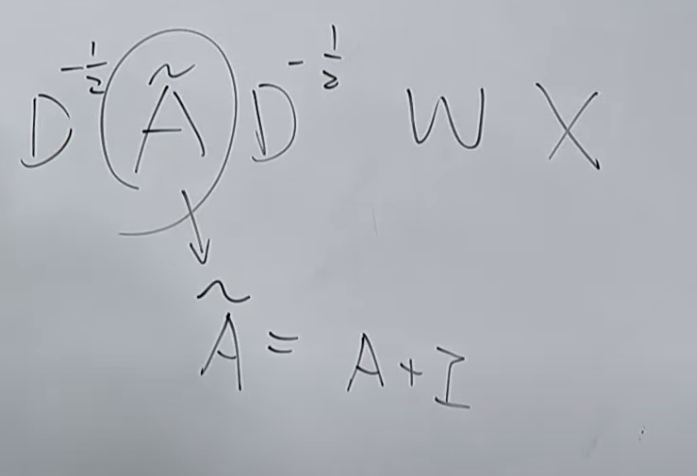

In [4]:
from IPython.display import Image
Image("/mnt/market/anclab-rstudio-server/home/mpir0002/GCNconv.png")

In [ ]:
# The image you've uploaded seems to represent a mathematical expression commonly used in Graph Convolutional Network (GCN) models. The expression is a formula for a layer in a GCN, where the graph structure is encoded in the adjacency matrix \( A \) and self-connections are added to it (\( A + I \), with \( I \) being the identity matrix). The degree matrix \( D \) is used for normalization, and \( W \) represents the trainable weight matrix of the layer.

# Here's a breakdown of the formula:

# - \( D^{-\frac{1}{2}} \): This is the inverse square root of the degree matrix \( D \). The degree matrix is diagonal with the degrees of the nodes (i.e., the number of connections each node has) on the diagonal. The operation \( D^{-\frac{1}{2}} \) normalizes the node degrees, which is important for preventing nodes with high degrees from having too much influence on the feature aggregation process.
# - \( \hat{A} \): This denotes the adjusted adjacency matrix, which is typically the adjacency matrix with added self-connections (\( A + I \)), making sure each node aggregates its own features along with its neighbors' features.
# - \( \hat{A} \): Again, representing the adjusted adjacency matrix.
# - \( W \): The weight matrix of the GCN layer that transforms the feature vectors from one dimension to another. This is where the learning happens as \( W \) is updated during the training process to learn the representations.
# - \( X \): The feature matrix containing the feature vector of each node.

# The complete operation \( D^{-\frac{1}{2}} \hat{A} D^{-\frac{1}{2}} W X \) represents one graph convolution operation in a GCN, where each node's features are updated based on its own features and the features of its neighbors. This formula is part of the propagation rule in GCNs, which generalizes the convolution operation from regular grids (like images) to graphs.

In [ ]:
# Here's an example of what the forward function might look like:

def forward(self, x, edge_index):
    # Step 1: Apply a linear transformation to the node features
    transformed_x = self.lin(x)

    # Step 2: Propagate the messages through the graph
    updated_features = self.propagate(edge_index, x=transformed_x)

    # Step 3: (Optional) Apply any post-processing like ReLU activation
    out = F.relu(updated_features)

    return out



In [ ]:
# Yes, that's correct. In the CustomConv class, which is a custom layer extending PyTorch Geometric's MessagePassing class, the forward function typically orchestrates the flow of data, including any initial transformations of the node features before the message passing begins. Here's the sequence of operations that usually happens in the forward function:

# Initial Transformations: First, the forward function might perform some initial transformations on the node features. This is common in graph convolution layers, where each node's features are linearly transformed before being used in message passing.

# Propagate: After transforming the features, the forward function then calls self.propagate, which initiates the message passing process. The propagate method itself handles the calling of message, aggregate, and update functions in a certain sequence:

# message: Defines how the messages are computed for each edge in the graph.
# aggregate: Gathers all the messages for each node and combines them together (e.g., sum, mean, etc.).
# update: Optionally modifies the aggregated messages before they become the new features of the nodes.
# Post-processing: Finally, after propagation, there might be additional steps such as applying activation functions or other transformations to the resulting features.

In [ ]:

#Here's a simple example of a propogation:
def forward(self, x, edge_index):
    # Pre-processing node features
    x = self.some_preprocessing(x)
    
    # Trigger message passing
    return self.propagate(edge_index, x=x)


In [ ]:

#Here's a simple example of a message function:
def message(self, x_i, x_j, edge_index, size):
    # Compute messages to be sent along the edges
    return x_j - x_i  # This is just a simple example


In [ ]:
#Comparison forward and message methods
#Purpose: forward orchestrates the overall flow of data through the layer, while message specifically defines the transformation of data that gets sent along the edges.
#Scope: forward has access to the entire layer's parameters and can perform global operations, whereas message generally deals with edge-level computations.
#Usage: forward is called directly during the forward pass of the model, while message is invoked internally by the propagate method when message passing occurs.

In [ ]:
# In the context of PyTorch Geometric's MessagePassing class, x_i and x_j represent the node feature vectors associated with each edge in the graph during the message passing phase.

# Here's what they specifically represent:

# x_i: The feature vectors of the destination nodes (or target nodes) of the edges. These are the nodes to which the messages are being sent in the aggregation process.

# x_j: The feature vectors of the source nodes (or origin nodes) of the edges. These are the nodes from which the messages originate.

# The propagate method calls the message function for each edge in the graph, and the PyTorch Geometric library automatically handles the indexing and passes the correct feature vectors (x_i and x_j) to the message function.

# When an edge is directed from node i to node j (i.e., the edge is (i, j)), x_i corresponds to the features of node j and x_j to the features of node i. It's set up this way because, conceptually, you are passing messages along the edges from x_j (source) to x_i (target) for aggregation.
# Here is a simplified visualization for a single edge in a graph:

# #Node i -----> Node j
# #  x_j          x_i



In [ ]:
# #what does size do?

# In the context of the message function of PyTorch Geometric's MessagePassing class, size is an argument that provides the sizes of the source and destination node feature matrices. When you're performing message passing, the edges in edge_index connect nodes from potentially two different sets, the source nodes and the destination nodes, which could be of different sizes in the case of bipartite graphs.

# The size tuple has two elements:

# size[0]: The size of the destination node set, which corresponds to the number of nodes that will receive messages (also referred to as the number of target nodes or node indices in the second row of edge_index).
# size[1]: The size of the source node set, which corresponds to the number of nodes that are sending messages (also referred to as the number of source nodes or node indices in the first row of edge_index).
# This argument is particularly useful when dealing with different sets of nodes, such as in bipartite graphs or when you're performing edge convolutions where the messages might come from a different set of nodes than they are being sent to.

# In the standard message passing on graphs (not bipartite), size[0] and size[1] will typically be equal to the number of nodes in the graph. If you do not specify size, PyTorch Geometric will infer it based on the maximum node index in edge_index

def message(self, x_j, edge_index, size):
    # Calculate degree for normalization based on the size of destination nodes
    row, _ = edge_index
    deg = pyg_utils.degree(row, size[0], dtype=x_j.dtype)

#In this case, size[0] is used to calculate the degrees of the destination nodes, which is essential for normalizing the messages properly in a GCN. This ensures that when aggregating messages, each node's incoming messages are weighted by the node's degree, which is part of the normalization step of the GCN propagation rule.



In [ ]:
# now we can replace GCNConv with CustomConv:

def build_conv_model(self, input_dim, hidden_dim):
        # refer to pytorch geometric nn module for different implementation of GNNs.
        if self.task == 'node':
            return CustomConv(input_dim, hidden_dim)
        else:
            return pyg_nn.GINConv(nn.Sequential(nn.Linear(input_dim, hidden_dim),
                                  nn.ReLU(), nn.Linear(hidden_dim, hidden_dim)))


In [ ]:
def train(dataset, task, writer):
    if task == 'graph':
        data_size = len(dataset)
        loader = DataLoader(dataset[:int(data_size * 0.8)], batch_size=64, shuffle=True)
        test_loader = DataLoader(dataset[int(data_size * 0.8):], batch_size=64, shuffle=True)
    else:
        test_loader = loader = DataLoader(dataset, batch_size=64, shuffle=True)

        #For graph-level tasks, explicitly splitting the dataset into distinct training and test sets is necessary because each graph is an independent sample.
        #For node-level tasks, the entire graph (or graphs) is used both for training and testing, with the model learning to classify nodes based on features and connectivity. The distinction between training and test nodes is typically managed internally by the dataset (e.g., through masks).
        
    # build model
    model = GNNStack(max(dataset.num_node_features, 1), 32, dataset.num_classes, task=task)
    opt = optim.Adam(model.parameters(), lr=0.01)
    
    # train
    for epoch in range(200):
        total_loss = 0
        model.train()
        for batch in loader:
            #print(batch.train_mask, '----')
            opt.zero_grad()
            embedding, pred = model(batch)
            label = batch.y
            if task == 'node':
                pred = pred[batch.train_mask]
                label = label[batch.train_mask]
            loss = model.loss(pred, label)
            loss.backward()
            opt.step()
            total_loss += loss.item() * batch.num_graphs
        total_loss /= len(loader.dataset)
        writer.add_scalar("loss", total_loss, epoch)

        if epoch % 10 == 0:
            test_acc = test(test_loader, model)
            print("Epoch {}. Loss: {:.4f}. Test accuracy: {:.4f}".format(
                epoch, total_loss, test_acc))
            writer.add_scalar("test accuracy", test_acc, epoch)

    return model


In [ ]:
## Training

This code snippet outlines a training loop for a model (likely a Graph Neural Network given the context) over a dataset for either graph-level or node-level tasks. The loop handles training, calculates loss, and periodically evaluates the model on a test set. Here's a detailed breakdown:

### Training Loop Overview
- **Epochs**: The model is trained for 200 epochs. Each epoch represents a full pass through the training dataset.
- **Model Mode**: Sets the model to training mode (`model.train()`), enabling certain layers like dropout and batch normalization to work in training mode.
- **Optimizer Zero Gradient**: Before each batch, it resets the gradients accumulated in the optimizer (`opt.zero_grad()`), ensuring that we start fresh for each backward pass.

### Batch Processing
- **Model Forward Pass**: For each batch, the model computes embeddings and predictions (`embedding, pred = model(batch)`). The structure suggests the model returns both raw embeddings and task-specific predictions.
- **Loss Computation**:
  - For node-level tasks (`'node'`), predictions and labels are masked to consider only those nodes designated for training (using `batch.train_mask`).
  - Loss is calculated using `model.loss(pred, label)`, likely a method within the model class that specifies the loss function.
- **Backward and Optimization**:
  - The loss is backpropagated (`loss.backward()`), and an optimization step is taken (`opt.step()`).
  - The total loss for the epoch is accumulated, considering the number of graphs in each batch (`batch.num_graphs`), which is important for averaging the loss correctly when batches may contain different numbers of graphs or nodes.

### Logging and Evaluation
- **Logging**: Training loss is logged using TensorBoard (`writer.add_scalar("loss", total_loss, epoch)`), allowing for visualization of training progress.
- **Periodic Testing**: Every 10 epochs, the model's accuracy is evaluated on the test set. This involves a separate function `test`, which likely calculates the model's accuracy based on predictions for the test_loader data. The test accuracy is also logged using TensorBoard.

### Important Considerations
- **Task-Specific Handling**: The code distinguishes between node and graph-level tasks, adjusting how predictions and labels are handled based on the task.
- **TensorBoard Logging**: Utilizes TensorBoard for logging, which helps in monitoring the model's learning curve and test performance over epochs.
- **Model Evaluation**: The periodic evaluation helps in understanding how well the model generalizes to unseen data over the course of training.

This training loop is fairly standard for training GNNs on PyTorch Geometric datasets, with good practices like zeroing gradients, loss computation, backward pass, and optimization steps clearly outlined. It also demonstrates the flexibility needed to handle different kinds of tasks (node vs. graph level) within the same framework.

In [ ]:
def test(loader, model, is_validation=False):
    model.eval()

    correct = 0
    for data in loader:
        with torch.no_grad():
            emb, pred = model(data)
            pred = pred.argmax(dim=1)
            label = data.y

        if model.task == 'node':
            mask = data.val_mask if is_validation else data.test_mask
            # node classification: only evaluate on nodes in test set
            pred = pred[mask]
            label = data.y[mask]
            
        correct += pred.eq(label).sum().item()
    
    if model.task == 'graph':
        total = len(loader.dataset) 
    else:
        total = 0
        for data in loader.dataset:
            total += torch.sum(data.test_mask).item()
    return correct / total